In [29]:
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
from torchvision import transforms

from segmentation.mask_rcnn import load_maskrcnn_model, get_prediction, white_out
from generation.pix2pix import load_pix2pix_model, get_recovered_image

In [30]:
if torch.cuda.is_available():
        device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

cwd = os.getcwd()

mask_rcnn_path = os.path.join(cwd, "segmentation/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth")
mask_rcnn = load_maskrcnn_model(device, mask_rcnn_path)

pix2pix_path = os.path.join(cwd, "generation/checkpoints/netG_model.pth")
net_g = load_pix2pix_model(device, pix2pix_path)

In [31]:
import time
import psutil

# Function to profile model
def profile_model(model, input_tensor):
    # Set model to evaluation mode
    model.eval()
    
    # Forward pass to warm-up memory allocation
    with torch.no_grad():
        model(input_tensor)
    
    # Profile inference time
    start_time = time.time()
    with torch.no_grad():
        model(input_tensor)
    end_time = time.time()
    inference_time = end_time - start_time
    
    # Profile memory usage
    #torch.cuda.reset_peak_memory_stats()
    start_memory = psutil.Process().memory_info().rss / (1024)  # Convert bytes to KB
    with torch.no_grad():
        model(input_tensor)
    #peak_memory_usage = torch.cuda.max_memory_allocated() / 1024**2  # Convert bytes to megabytes
    end_memory = psutil.Process().memory_info().rss / (1024)  # Convert bytes to KB
    peak_memory_usage = end_memory - start_memory
    
    return inference_time, peak_memory_usage



Classes: {'vase', 'potted plant'}


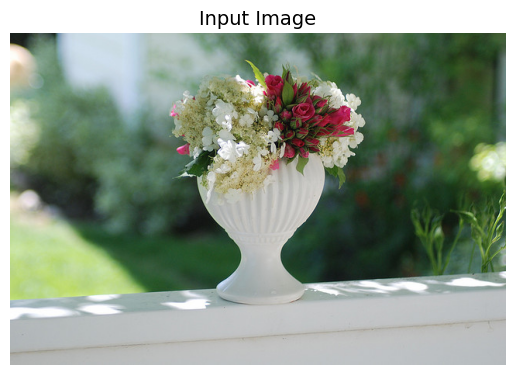

In [32]:
input_image = os.path.join(cwd, "test_images/000000000030.jpg")
image = Image.open(input_image)
input_tensor_img = transforms.ToTensor()(image)

fig, axes = plt.subplots()
axes.imshow(image)
axes.set_title("Input Image", fontsize=14)
axes.axis('off')

img_tensor, masks, preds = get_prediction(image, 0.5, mask_rcnn, device)
classes = set()
for i in range(len(masks)):
    classes.add(preds[i])
options = list(classes)



print("Classes:", classes)
plt.show()
image.close()

In [35]:
## Object removal
## Type object class to remove
selected_option = "vase"
instance_removed_img = white_out(img_tensor, masks, preds, selected_option)
# fig, axes = plt.subplots()
# axes.imshow(instance_removed_img)
# axes.set_title("Object removed", fontsize=14)
# axes.axis('off')


(-0.5, 639.5, 427.5, -0.5)

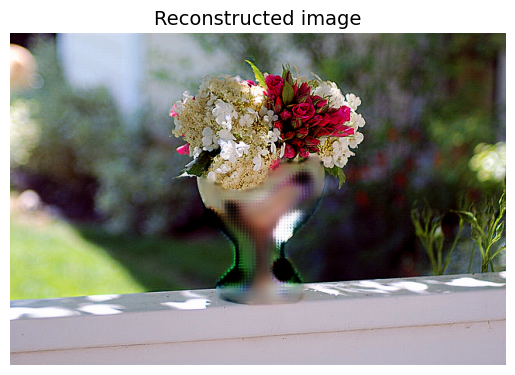

In [36]:
image_pil = get_recovered_image(instance_removed_img, net_g, device)
fig, axes = plt.subplots()
axes.imshow(image_pil)
axes.set_title("Reconstructed image", fontsize=14)
axes.axis('off')

In [40]:
import torch.quantization
import torch.nn.utils.prune as prune

doPruning = 1

# Quantize the Mask RCNN model
quantized_mask_rcnn = torch.quantization.quantize_dynamic(
    mask_rcnn, {torch.nn.Conv2d}, dtype=torch.qint8
)

# Quantize the Pix2Pix model
quantized_net_g = torch.quantization.quantize_dynamic(
    net_g, {torch.nn.Conv2d, torch.nn.Linear}, dtype=torch.qint8
)

if (doPruning):
    # Prune the Mask RCNN model
    for name, module in quantized_mask_rcnn.named_modules():
        # prune 20% of connections in all 2D-conv layers 
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=0.2)
        # prune 40% of connections in all linear layers 
        # elif isinstance(module, torch.nn.Linear):
        #     prune.l1_unstructured(module, name='weight', amount=0.4)
    
    # Prune the Pix2Pix model
    for name, module in quantized_net_g.named_modules():
        # prune 20% of connections in all 2D-conv layers 
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=0.2)
        # prune 40% of connections in all linear layers 
        # elif isinstance(module, torch.nn.Linear):
        #     prune.l1_unstructured(module, name='weight', amount=0.4)

In [41]:
# Profile original Mask RCNN model
#print(input_tensor_img.shape)
height = input_tensor_img.shape[1]
width = input_tensor_img.shape[2]
input_tensor = torch.randn(1, 3, height, width, device=device)
original_inference_time, original_peak_memory_usage = profile_model(mask_rcnn, input_tensor)

# Profile optimized Mask RCNN model
quantized_inference_time, quantized_peak_memory_usage = profile_model(quantized_mask_rcnn, input_tensor)

# Print results
print("Original Mask RCNN - Inference Time:", original_inference_time, "seconds, Peak Memory Usage:", original_peak_memory_usage, "KB")
print("Quantized Mask RCNN - Inference Time:", quantized_inference_time, "seconds, Peak Memory Usage:", quantized_peak_memory_usage, "KB")

Original Mask RCNN - Inference Time: 1.4871013164520264 seconds, Peak Memory Usage: 0.0 KB
Quantized Mask RCNN - Inference Time: 1.546083927154541 seconds, Peak Memory Usage: 13596.0 KB


In [39]:
# Profile original Pix2Pix
original_inference_time, original_peak_memory_usage = profile_model(net_g, input_tensor)

# Profile optimized Pix2Pix
quantized_inference_time, quantized_peak_memory_usage = profile_model(quantized_net_g, input_tensor)

# Print results
print("Original Pix2Pix - Inference Time:", original_inference_time, "seconds, Peak Memory Usage:", original_peak_memory_usage, "KB")
print("Quantized Pix2Pix - Inference Time:", quantized_inference_time, "seconds, Peak Memory Usage:", quantized_peak_memory_usage, "KB")

Original Pix2Pix - Inference Time: 1.1240489482879639 seconds, Peak Memory Usage: 0.0 KB
Quantized Pix2Pix - Inference Time: 1.0982227325439453 seconds, Peak Memory Usage: 32.0 KB
